In [1]:
import json
import tensorflow as tf
from tensorflow.keras import Input
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# Configuring TensorFlow to use GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


#### Datasets

In [2]:
# drugs
drugs = pd.read_csv('../data/drugs.csv', index_col=1)
drugs.drop(['Unnamed: 0'], axis=1, inplace=True)

# cell lines
cell_lines = pd.read_csv('../data/gene_expression.csv', index_col=0)

# combinations
combinations = pd.read_csv('../data/combinations.csv', index_col=0)

In [5]:
# reduce cell lines to the 2128 most important genes

with open('../data/2128_genes.pkl', 'rb') as f:
    top_genes = pickle.load(f)

filtered_cell_lines = cell_lines[cell_lines.columns.intersection(top_genes)]

In [4]:
combinations

,Drug_ID,Cell Line_ID,Y
0,Camptothecin,HCC1954,-0.251083
1,Camptothecin,HCC1143,1.343315
2,Camptothecin,HCC1187,1.736985
3,Camptothecin,HCC1395,-2.309078
4,Camptothecin,HCC1599,-3.106684
...,...,...,...
92698,JQ1,EFM-192A,3.576583
92699,JQ1,HCC1428,1.402466
92700,JQ1,HDQ-P1,2.762460
92701,JQ1,JIMT-1,3.442930


### Merge data

In [5]:
drugs

,Drug
Drug_ID,
Camptothecin,CC[C@@]1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=...
Vinblastine,CC[C@@]1(CC2C[C@@](C3=C(CCN(C2)C1)C4=CC=CC=C4N...
Cisplatin,N.N.[Cl-].[Cl-].[Pt+2]
Cytarabine,C1=CN(C(=O)N=C1N)[C@H]2[C@H]([C@@H]([C@H](O2)C...
Docetaxel,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...
...,...
LJI308,C1COCCN1C2=CC=C(C=C2)C3=C(C=NC=C3)C4=CC(=C(C(=...
GSK591,C1CC(C1)NC2=NC=CC(=C2)C(=O)NC[C@@H](CN3CCC4=CC...
VE821,CS(=O)(=O)C1=CC=C(C=C1)C2=CN=C(C(=N2)C(=O)NC3=...


In [6]:
# transform smiles to fingerprints
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    return fp

def smiles_to_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = MACCSkeys.GenMACCSKeys(mol)
    return fp

drugs['Drug'] = drugs['Drug'].apply(smiles_to_fingerprint)
drugs

,Drug
Drug_ID,
Camptothecin,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Vinblastine,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
Cisplatin,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Cytarabine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Docetaxel,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
...,...
LJI308,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
GSK591,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
VE821,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
drugs = pd.concat([drugs.drop(['Drug'], axis=1), drugs['Drug'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)
drugs

,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,fp10,fp11,fp12,fp13,fp14,fp15,fp16,fp17,fp18,fp19,fp20,fp21,fp22,fp23,fp24,fp25,fp26,fp27,fp28,fp29,fp30,fp31,fp32,fp33,fp34,fp35,fp36,fp37,fp38,fp39,...,fp984,fp985,fp986,fp987,fp988,fp989,fp990,fp991,fp992,fp993,fp994,fp995,fp996,fp997,fp998,fp999,fp1000,fp1001,fp1002,fp1003,fp1004,fp1005,fp1006,fp1007,fp1008,fp1009,fp1010,fp1011,fp1012,fp1013,fp1014,fp1015,fp1016,fp1017,fp1018,fp1019,fp1020,fp1021,fp1022,fp1023
Drug_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Camptothecin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Vinblastine,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
Cisplatin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Cytarabine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
Docetaxel,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LJI308,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
GSK591,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
VE821,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# merge cell lines and drugs considering the combinations
final_df = pd.merge(combinations, drugs, on='Drug_ID')
final_df = pd.merge(final_df, filtered_cell_lines, left_on='Cell Line_ID', right_index=True, how = 'inner')
final_df.index = final_df['Drug_ID'] + '_' + final_df['Cell Line_ID']
final_df

,Drug_ID,Cell Line_ID,Y,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,fp10,fp11,fp12,fp13,fp14,fp15,fp16,fp17,fp18,fp19,fp20,fp21,fp22,fp23,fp24,fp25,fp26,fp27,fp28,fp29,fp30,fp31,fp32,fp33,fp34,fp35,fp36,...,PPP1R3G,EBF2,KRTAP1-5,OR2A12,OR2F2,MYBPHL,SMIM13,NOL7,DCAF8L1,OST4,ANKRD66,RPS18,TSPAN19,ZNF736,ZBTB22,B3GNT9,CDKN2AIPNL,KRTAP13-3,TNFRSF13B,PNMA2,CRCP,CD302,PEG10,DECR2,PSG4,LEFTY1,LCE3C,HS3ST5,PDCD6,TMEM158,ATP6V1E2,ZNF345,ATXN7L3B,PRKDC,PBOV1,OR13A1,ZNF253,MRPL46,OR1D5,MYH4
Camptothecin_HCC1954,Camptothecin,HCC1954,-0.251083,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,...,3.501092,2.977223,2.792560,3.050778,3.582201,2.974439,4.865992,10.548460,2.668223,10.553367,3.053911,4.936668,2.904937,2.902589,3.324814,3.632659,3.802032,3.183963,3.385512,3.070302,5.853940,4.849876,3.562930,6.203263,3.608111,3.086372,3.080336,2.699224,5.397571,4.745626,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Vinblastine_HCC1954,Vinblastine,HCC1954,-3.058914,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,...,3.501092,2.977223,2.792560,3.050778,3.582201,2.974439,4.865992,10.548460,2.668223,10.553367,3.053911,4.936668,2.904937,2.902589,3.324814,3.632659,3.802032,3.183963,3.385512,3.070302,5.853940,4.849876,3.562930,6.203263,3.608111,3.086372,3.080336,2.699224,5.397571,4.745626,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Cisplatin_HCC1954,Cisplatin,HCC1954,5.005908,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.501092,2.977223,2.792560,3.050778,3.582201,2.974439,4.865992,10.548460,2.668223,10.553367,3.053911,4.936668,2.904937,2.902589,3.324814,3.632659,3.802032,3.183963,3.385512,3.070302,5.853940,4.849876,3.562930,6.203263,3.608111,3.086372,3.080336,2.699224,5.397571,4.745626,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Cytarabine_HCC1954,Cytarabine,HCC1954,3.947056,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.501092,2.977223,2.792560,3.050778,3.582201,2.974439,4.865992,10.548460,2.668223,10.553367,3.053911,4.936668,2.904937,2.902589,3.324814,3.632659,3.802032,3.183963,3.385512,3.070302,5.853940,4.849876,3.562930,6.203263,3.608111,3.086372,3.080336,2.699224,5.397571,4.745626,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Docetaxel_HCC1954,Docetaxel,HCC1954,-4.177968,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,...,3.501092,2.977223,2.792560,3.050778,3.582201,2.974439,4.865992,10.548460,2.668223,10.553367,3.053911,4.936668,2.904937,2.902589,3.324814,3.632659,3.802032,3.183963,3.385512,3.070302,5.853940,4.849876,3.562930,6.203263,3.608111,3.086372,3.080336,2.699224,5.397571,4.745626,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MK-2206_HCC202,MK-2206,HCC202,1.585069,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,3.723816,2.898393,2.937383,3.234417,3.951380,3.252830,3.898766,10.096549,2.733110,11.968360,2.923517,3.956952,3.059150,2.978888,3.123761,3.986667,3.893581,2.940331,3.633345,3.086599,6.521196,7.043011,5.093262,6.244056,3.986983,3.132335,3.120847,2.849185,6.124334,4.942865,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
Palbociclib_HCC202,Palbociclib,HCC202,4.867165,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,...,3.723816,2.898393,2.937383,3.234417,3.951380,3.252830,3.898766,10.096549,2.733110,11.968360,2.923517,3.956952,3.059150,2.978888,3.123761,3.986667,3

In [9]:
# selected_columns = final_df.filter(regex='^fp', axis=1)
# selected_columns

In [10]:
# selected_columns = final_df.iloc[:, final_df.columns.get_loc('fp1023') + 1:]
# selected_columns

### Dataset splitting ###

In [11]:
output = final_df['Y']
input = final_df.drop(['Drug_ID', 'Cell Line_ID', 'Y'], axis=1)

In [12]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(input)
# input = scaler.transform(input)

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(input, output, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

In [14]:
x_train_drugs = x_train.filter(regex='^fp', axis=1)
x_train_cell_lines = x_train.iloc[:, x_train.columns.get_loc('fp1023') + 1:]

x_val_drugs = x_val.filter(regex='^fp', axis=1)
x_val_cell_lines = x_val.iloc[:, x_val.columns.get_loc('fp1023') + 1:]

x_test_drugs = x_test.filter(regex='^fp', axis=1)
x_test_cell_lines = x_test.iloc[:, x_test.columns.get_loc('fp1023') + 1:]

In [15]:
# from sklearn.preprocessing import StandardScaler
# scaler_train = StandardScaler()
# scaler_train.fit(x_train)
# x_train = scaler_train.transform(x_train)

# scaler_val = StandardScaler()
# scaler_val.fit(x_val)
# x_val = scaler_val.transform(x_val)

# scaler_test = StandardScaler()
# scaler_test.fit(x_test)
# x_test = scaler_test.transform(x_test)

### build dense attention layer

In [14]:
from ..models import DenseModel


# Example usage

model = DenseModel(x_train_cell_lines.shape[1], x_train_drugs.shape[1], optimizer='SGD')
print(model.summary())
model.train(x_train_cell_lines, x_train_drugs, y_train, epochs=10, batch_size=16)

val_loss, val_mae = model.evaluate(x_val_cell_lines, x_val_drugs, y_val)
print(f'Test Loss: {val_loss}, Test MAE: {val_mae}')

predictions = model.predict(x_test_cell_lines, x_test_drugs)
print(predictions)


ImportError: attempted relative import with no known parent package

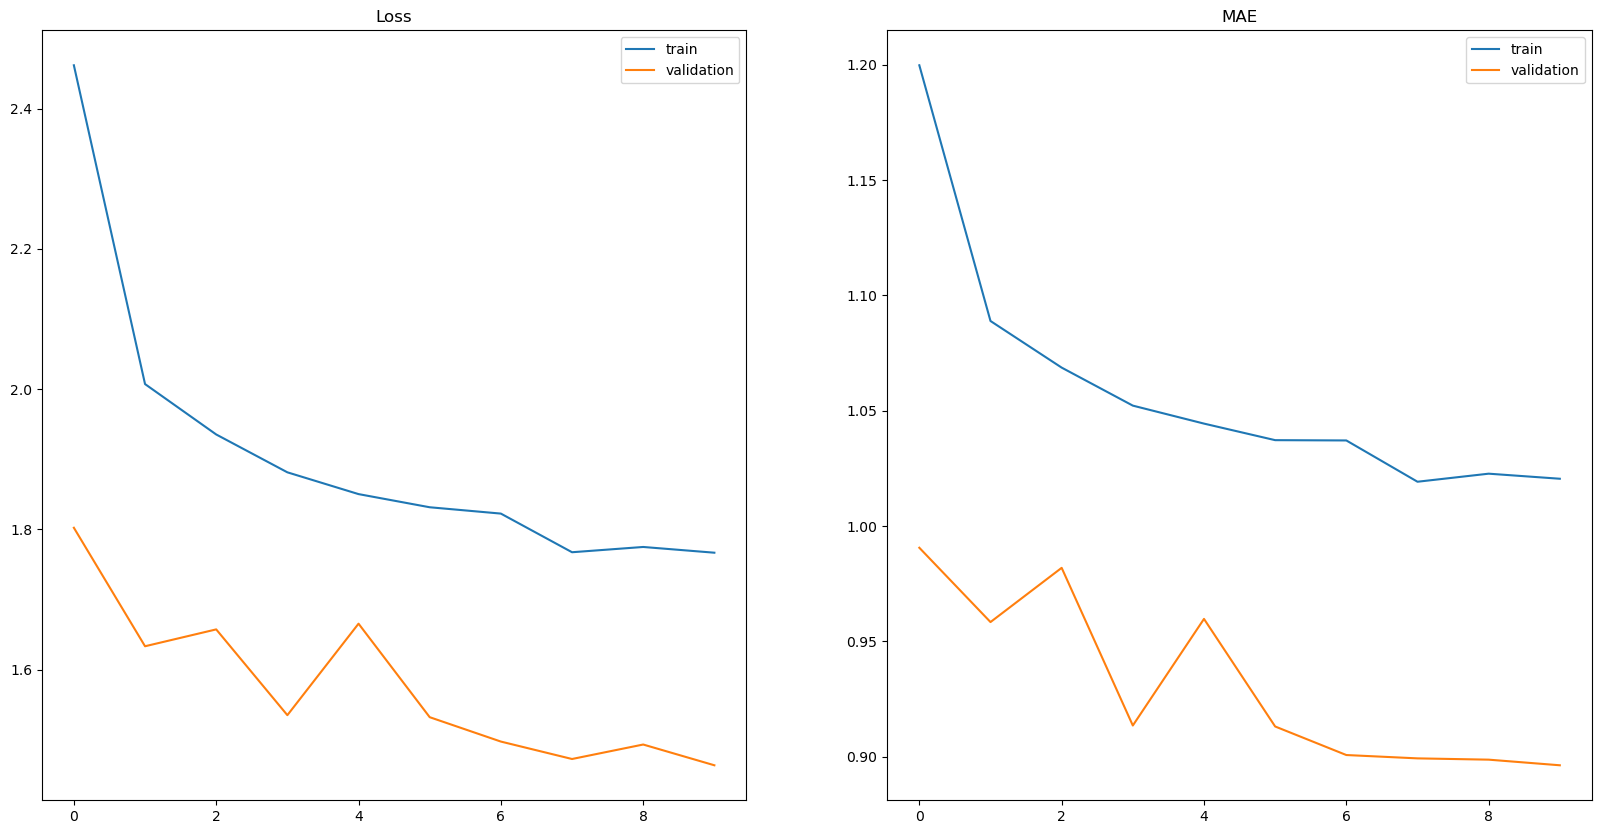

In [17]:
#plot loss and mae from training and validation data side by side
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model.history.history['mae'], label='train')
plt.plot(model.history.history['val_mae'], label='validation')
plt.title('MAE')
plt.legend()
plt.show()



